<a href="https://colab.research.google.com/github/rrwiren/ilmanlaatu-ennuste-helsinki/blob/main/GRU-malli%20_PyTorch_v7-pilkottu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title 0. Esitiedot ja Ajo-ohjeet (YKSI TIEDOSTO VERSIO v7 - Pilkottu)
"""
Otsoniennuste Helsinki - Paranneltu GRU-malli (PyTorch) v7 - Pilkottu

Tämä on yksi yhtenäinen skripti, joka sisältää kaikki aiemmat korjaukset
ja parannukset. Se lataa esikäsitellyn otsoni- ja säädatan, muokkaa
ominaisuuksia, kouluttaa GRU-mallin ja arvioi sitä monipuolisesti.
Tämä versio toimitetaan osissa (@title-lohko kerrallaan) kopioinnin
helpottamiseksi ja oikeiden sisennysten varmistamiseksi.

AJO-OHJEET COLABISSA:
1. Luo uusi Colab-muistikirja.
2. Kopioi KUKIN alla oleva `@title`-lohko OMAAN ERILLISEEN soluunsa
   Colab-muistikirjassa (yhteensä 10 solua, 0-9).
3. Aja kaikki solut järjestyksessä (Runtime -> Run all tai solu kerrallaan).
4. Tarkastele tulosteita ja kuvaajia lopussa.
"""
print("Osa 0: Esitiedot - OK")

Osa 0: Esitiedot - OK


In [2]:
# @title 1. Asennukset ja Tuonnit (Installations and Imports)
# Asennetaan tarvittavat kirjastot (tarvittaessa Colabissa)
# !pip install pandas numpy scikit-learn matplotlib torch pyarrow fastparquet -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split # Ei käytetä lopullisessa jaossa
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import requests
import io
import os
from tqdm.notebook import tqdm # Edistymispalkki Colabissa
import math
import copy # Tarvitaan mallin tilan kopiointiin Early Stoppingissa
import traceback # Tuodaan traceback virheen jäljitystä varten

# Asetetaan laite (GPU jos saatavilla, muuten CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Käytetään laitetta: {device}")
print("Osa 1: Tuonnit - OK")

Käytetään laitetta: cpu
Osa 1: Tuonnit - OK


In [3]:
# @title 2. Parametrit ja Asetukset (Parameters and Settings)

# --- Data ja GitHub ---
GITHUB_DATA_URL = 'https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/processed/processed_hourly_ozone_weather_data.parquet'
LOCAL_DATA_PATH = 'processed_hourly_ozone_weather_data.parquet' # Ladataan tähän tiedostoon

# --- Datan sarakkeet (tarkistettu vastaamaan tiedostoa) ---
TARGET_COLUMN = 'Otsoni [µg/m³]' # Tämä on ennustettava kohde
ORIGINAL_FEATURE_COLUMNS = [      # Alkuperäiset sarakkeet datassa, joita käytetään
    'Otsoni [µg/m³]',             # Käytetään myös historiallista O3:sta piirteenä
    'Lämpötilan keskiarvo [°C]',
    'Keskituulen nopeus [m/s]',
    'Ilmanpaineen keskiarvo [hPa]',
    'Tuulen suunnan keskiarvo [°]'
]
# Huom: Muokatut ominaisuudet (aika, tuulensuunta sin/cos) lisätään myöhemmin koodissa

# Aikasarjaparametrit
SEQUENCE_LENGTH = 72  # Kuinka monta tuntia historiaa käytetään syötteenä (esim. 3 vrk)
PREDICTION_HORIZON = 24 # Kuinka monta tuntia eteenpäin ennustetaan

# --- GRU-mallin Hyperparametrit ---
# INPUT_SIZE lasketaan myöhemmin feature engineeringin jälkeen
HIDDEN_SIZE = 64          # GRU-kerroksen piilotilan koko
NUM_LAYERS = 2            # GRU-kerrosten määrä
OUTPUT_SIZE = PREDICTION_HORIZON # Ennustetaan kaikki 24 tuntia kerralla
DROPOUT_PROB = 0.2        # Dropout-todennäköisyys regularisointiin

# --- Koulutusparametrit ---
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 50              # Voit lisätä epochien määrää tarvittaessa
TEST_SPLIT_RATIO = 0.15   # Testijoukon osuus (viimeisimmät tiedot)
VALID_SPLIT_RATIO = 0.15  # Validointijoukon osuus (ennen testijoukkoa)
EARLY_STOPPING_PATIENCE = 7 # Kärsivällisyys Early Stoppingille

# --- Varoitusraja (8h liukuva keskiarvo) ---
O3_THRESHOLD_8H_AVG = 120 # µg/m³ (Virallinen varoitusraja)

# --- Satunnaisuuden kiinnitys vertailtavuuden vuoksi ---
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Nämä voivat hidastaa ajoa, mutta parantavat toistettavuutta GPU:lla
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Osa 2: Parametrit ja Asetukset - OK")

Osa 2: Parametrit ja Asetukset - OK


In [4]:
# @title 3. Funktiot Datan Lataukseen ja Käsittelyyn

def download_data(url, local_path):
    """Lataa tiedoston URL:sta paikalliseen polkuun."""
    try:
        print(f"Yritetään ladata dataa osoitteesta {url}...")
        response = requests.get(url)
        response.raise_for_status() # Tarkistaa virheet (esim. 404 Not Found)
        with open(local_path, 'wb') as f:
            f.write(response.content)
        print(f"Data ladattu onnistuneesti: {local_path}")
        return True
    except requests.exceptions.RequestException as e:
        print(f"Virhe datan latauksessa: {e}")
        return False

def load_data(filepath):
    """Lataa datan parquet-tiedostosta ja suorittaa perustarkistukset (KORJATTU VERSIO)."""
    if not os.path.exists(filepath):
        print(f"Tiedostoa {filepath} ei löytynyt paikallisesti.")
        if not download_data(GITHUB_DATA_URL, filepath):
            return None # Lopeta jos lataus epäonnistui

    try:
        print(f"Ladataan dataa tiedostosta: {filepath}")
        df = pd.read_parquet(filepath)
        print("Parquet-tiedosto ladattu.")

        # --- Aikaindeksin varmistus ---
        if not isinstance(df.index, pd.DatetimeIndex):
             if 'timestamp' in df.columns: # Yleinen nimi aikaleimalle
                  df['timestamp'] = pd.to_datetime(df['timestamp'])
                  df.set_index('timestamp', inplace=True)
                  print("Muutettu 'timestamp'-sarake indeksiksi.")
             else:
                 try:
                    df.index = pd.to_datetime(df.index)
                    print("Muutettu olemassaoleva indeksi datetime-indeksiksi.")
                 except Exception as e:
                    print(f"Indeksin muuttaminen datetimeksi epäonnistui: {e}")
                    print("Varmista, että datassa on aikaleimaindeksi tai 'timestamp'-sarake.")
                    return None

        df.sort_index(inplace=True) # Varmista aikajärjestys

        print(f"\nDatan perustiedot:")
        print(f"Muoto: {df.shape}")
        print(f"Aikaväli: {df.index.min()} - {df.index.max()}")
        print(f"Kaikki ladatut sarakkeet: {df.columns.tolist()}")

        # --- Puuttuvien arvojen käsittely ---
        print("\nPuuttuvat arvot per sarake (ennen täyttöä):")
        null_counts_before = df.isnull().sum()
        print(null_counts_before)
        if null_counts_before.sum() > 0:
            print("Täytetään puuttuvat arvot (ffill + bfill)...")
            df.ffill(inplace=True)
            df.bfill(inplace=True)
            print("\nPuuttuvat arvot täytön jälkeen:")
            null_counts_after = df.isnull().sum()
            print(null_counts_after)
            # Tarkistetaan uudelleen, jos bfill ei auttanut alkuun
            if null_counts_after.sum() > 0:
                 print("VAROITUS: Datan sisältää edelleen puuttuvia arvoja! Poistetaan rivit.")
                 df.dropna(inplace=True)
                 print(f"Datan muoto NaN-rivien poiston jälkeen: {df.shape}")
        else:
            print("Ei puuttuvia arvoja.")

        print("\nDatan lataus ja peruspuhdistus valmiit.")
        # Palautetaan koko ladattu ja puhdistettu DataFrame
        return df

    except Exception as e:
        print(f"Virhe datan käsittelyssä load_data funktiossa: {e}")
        traceback.print_exc() # Tulosta traceback debuggausta varten
        return None

def feature_engineer(df):
    """Lisää aika- ja syklisiä ominaisuuksia DataFrameen."""
    print("\nSuoritetaan ominaisuuksien muokkaus (Feature Engineering)...")
    if not isinstance(df, pd.DataFrame):
        print("VIRHE: feature_engineer sai syötteenä jotain muuta kuin DataFramen.")
        return None
    df_eng = df.copy()
    engineered_cols = [] # Kerätään uusien sarakkeiden nimet

    # 1. Kellonaika (syklinen)
    try:
        df_eng['hour'] = df_eng.index.hour
        df_eng['hour_sin'] = np.sin(2 * np.pi * df_eng['hour'] / 24.0)
        df_eng['hour_cos'] = np.cos(2 * np.pi * df_eng['hour'] / 24.0)
        df_eng.drop('hour', axis=1, inplace=True) # Poista alkuperäinen tuntisarake
        engineered_cols.extend(['hour_sin', 'hour_cos'])
        print("Lisätty syklinen kellonaika (hour_sin, hour_cos).")
    except AttributeError:
         print("VAROITUS: Ei voitu lisätä kellonaikaominaisuuksia (indeksi ei ehkä ole DatetimeIndex?).")
    except Exception as e:
         print(f"VIRHE kellonaikaominaisuuksien luonnissa: {e}")


    # 2. Tuulen suunta (syklinen)
    wind_dir_col = 'Tuulen suunnan keskiarvo [°]'
    if wind_dir_col in df_eng.columns:
        try:
            df_eng['wind_dir_rad'] = np.deg2rad(df_eng[wind_dir_col])
            df_eng['wind_dir_sin'] = np.sin(df_eng['wind_dir_rad'])
            df_eng['wind_dir_cos'] = np.cos(df_eng['wind_dir_rad'])
            # Poista alkuperäinen tuulensuunta asteina ja radiaaneina
            df_eng.drop([wind_dir_col, 'wind_dir_rad'], axis=1, inplace=True)
            engineered_cols.extend(['wind_dir_sin', 'wind_dir_cos'])
            print("Muunnettu tuulen suunta sykliseksi (wind_dir_sin, wind_dir_cos).")
        except Exception as e:
            print(f"VIRHE tuulensuuntaominaisuuksien luonnissa: {e}")
            # Jos virhe, poista mahdollisesti luodut väliaikaiset sarakkeet
            if 'wind_dir_rad' in df_eng.columns: df_eng.drop('wind_dir_rad', axis=1, inplace=True)
            if 'wind_dir_sin' in df_eng.columns: df_eng.drop('wind_dir_sin', axis=1, inplace=True)
            if 'wind_dir_cos' in df_eng.columns: df_eng.drop('wind_dir_cos', axis=1, inplace=True)

    else:
        print(f"Saraketta '{wind_dir_col}' ei löytynyt, tuulensuunnan muokkausta ei tehty.")

    print("Ominaisuuksien muokkaus valmis.")
    print(f"Muokattu DataFrame sisältää nyt sarakkeet: {df_eng.columns.tolist()}")
    return df_eng

def create_sequences(features_scaled, targets_original, sequence_length, prediction_horizon):
    """
    Luo syötesekvenssejä (skaalattu) ja alkuperäisiä kohde-ennusteita.
    """
    X, y_orig = [], []
    print(f"Luodaan sekvenssejä: sequence_length={sequence_length}, prediction_horizon={prediction_horizon}")
    print(f"features_scaled shape: {features_scaled.shape}, targets_original shape: {targets_original.shape}")
    # Varmistetaan, että dataa on tarpeeksi
    required_len = sequence_length + prediction_horizon
    if len(features_scaled) < required_len:
        print(f"VAROITUS: Ei tarpeeksi dataa ({len(features_scaled)}) sekvenssien luomiseen. Tarvitaan vähintään {required_len}.")
        return np.array(X), np.array(y_orig) # Palautetaan tyhjät arrayt

    # Loopataan niin, että viimeinen y alkaa kohdasta len - prediction_horizon
    for i in range(len(features_scaled) - required_len + 1):
        X.append(features_scaled[i:(i + sequence_length)])
        # Otetaan vain O3-arvot (target) ennustejaksolle alkuperäisestä datasta
        y_orig.append(targets_original[i + sequence_length : i + sequence_length + prediction_horizon])

    print(f"Luotu {len(X)} sekvenssiä.")
    # Muunnetaan numpy-arrayksi lopuksi
    X = np.array(X)
    y_orig = np.array(y_orig)
    # Varmistetaan y_orig muoto (samples, horizon, 1) jos targets_original oli (N, 1)
    if y_orig.ndim == 2 and targets_original.ndim == 2 and targets_original.shape[1] == 1:
         y_orig = y_orig[..., np.newaxis]
         print(f"Muutettu y_orig muotoon: {y_orig.shape}")

    return X, y_orig

print("Osa 3: Funktiot datan käsittelyyn - OK")

Osa 3: Funktiot datan käsittelyyn - OK


In [5]:
# @title 4. Pääskriptin Suoritus: Datan Käsittely

# === PÄÄSKRIPTIN SUORITUSLOGIIKKA ALKAA TÄSTÄ ===

# --- Alustetaan muuttujat siltä varalta, että jokin vaihe epäonnistuu ---
df_raw = None
df_engineered = None
train_loader = None
valid_loader = None
test_loader = None
o3_scaler = None
feature_scaler = None
INPUT_SIZE = None
model = None
test_preds_orig = None
test_targets_orig = None
test_timestamps = None
X_train, y_train_original, X_valid, y_valid_original, X_test, y_test_original = [None]*6
y_train_scaled, y_valid_scaled = None, None

# --- Ladataan data ---
df_raw_full = load_data(LOCAL_DATA_PATH) # Ladataan ensin kaikki sarakkeet

if df_raw_full is not None:
    try: # Lisätään try-except koko datan käsittelylohkon ympärille
        # --- TARKISTETAAN TARVITTAVAT SARAKKEET ---
        print("\nTarkistetaan vaadittujen sarakkeiden olemassaolo...")
        required_cols_for_features = ORIGINAL_FEATURE_COLUMNS
        all_required_cols = list(set(required_cols_for_features + [TARGET_COLUMN]))

        missing_cols = [col for col in all_required_cols if col not in df_raw_full.columns]

        if missing_cols:
            print(f"\nVIRHE: Seuraavia vaadittuja sarakkeita ei löytynyt ladatusta datasta: {missing_cols}")
            raise ValueError(f"Vaadittuja sarakkeita puuttuu, ei voida jatkaa: {missing_cols}")
        else:
            print("Kaikki vaaditut sarakkeet löytyivät.")
            # Valitaan vain ne sarakkeet, jotka määriteltiin ORIGINAL_FEATURE_COLUMNS-listassa
            df_raw = df_raw_full[ORIGINAL_FEATURE_COLUMNS].copy()

        # --- Ominaisuuksien muokkaus ---
        df_engineered = feature_engineer(df_raw)
        if df_engineered is None: raise ValueError("Ominaisuuksien muokkaus epäonnistui.")

        FINAL_FEATURE_COLUMNS = df_engineered.columns.tolist()
        INPUT_SIZE = len(FINAL_FEATURE_COLUMNS)
        if INPUT_SIZE == 0: raise ValueError("Ominaisuuksien muokkauksen jälkeen ei jäänyt yhtään ominaisuutta.")
        print(f"\nLopullinen ominaisuuksien määrä (INPUT_SIZE): {INPUT_SIZE}")
        print(f"Lopulliset ominaisuudet mallille: {FINAL_FEATURE_COLUMNS}")

        # --- Datan Jako (Train, Validation, Test) ---
        n = len(df_engineered)
        min_data_len_needed = (SEQUENCE_LENGTH + PREDICTION_HORIZON) * 3 # Karkea arvio
        if n < min_data_len_needed:
             print(f"VAROITUS: Datan pituus ({n}) voi olla liian lyhyt jakoon ja sekvenssien luontiin (tarvitaan arviolta > {min_data_len_needed}).")
             # Ei nosteta virhettä vielä, mutta tarkistetaan jaon jälkeen

        test_split_idx = int(n * (1 - TEST_SPLIT_RATIO))
        valid_split_idx = int(test_split_idx * (1 - VALID_SPLIT_RATIO / (1 - TEST_SPLIT_RATIO)))

        df_train = df_engineered[:valid_split_idx]
        df_valid = df_engineered[valid_split_idx:test_split_idx]
        df_test = df_engineered[test_split_idx:]

        # Varmistetaan, että jokaisessa jaossa on tarpeeksi dataa sekvensseille
        min_len_for_seq = SEQUENCE_LENGTH + PREDICTION_HORIZON
        if len(df_train) < min_len_for_seq or len(df_valid) < min_len_for_seq or len(df_test) < min_len_for_seq:
            print(f"Train len: {len(df_train)}, Valid len: {len(df_valid)}, Test len: {len(df_test)}, Min required for sequence: {min_len_for_seq}")
            raise ValueError("Liian vähän dataa yhdessä tai useammassa jaossa sekvenssien luontia varten.")

        print(f"\nDatan jako:")
        print(f"Train: {df_train.shape[0]} riviä ({df_train.index.min()} - {df_train.index.max()})")
        print(f"Valid: {df_valid.shape[0]} riviä ({df_valid.index.min()} - {df_valid.index.max()})")
        print(f"Test:  {df_test.shape[0]} riviä ({df_test.index.min()} - {df_test.index.max()})")

        # --- Skaalaus ---
        feature_scaler = StandardScaler()
        scaled_train_features = feature_scaler.fit_transform(df_train)
        scaled_valid_features = feature_scaler.transform(df_valid)
        scaled_test_features = feature_scaler.transform(df_test)
        print("Ominaisuudet skaalattu (sovitettu vain harjoitusdataan).")

        o3_scaler = StandardScaler()
        o3_scaler.fit(df_raw.loc[df_train.index, [TARGET_COLUMN]])
        print("Erillinen skaalain luotu ja sovitettu kohdemuuttujalle (O3).")

        # Haetaan ALKUPERÄISET O3-kohdearvot jakojen mukaisesti
        o3_train_targets_original = df_raw.loc[df_train.index, [TARGET_COLUMN]].values
        o3_valid_targets_original = df_raw.loc[df_valid.index, [TARGET_COLUMN]].values
        o3_test_targets_original = df_raw.loc[df_test.index, [TARGET_COLUMN]].values


        # --- Sekvenssien Luonti ---
        print("\nLuodaan aikasarjasekvenssejä...")
        X_train, y_train_original = create_sequences(scaled_train_features, o3_train_targets_original, SEQUENCE_LENGTH, PREDICTION_HORIZON)
        X_valid, y_valid_original = create_sequences(scaled_valid_features, o3_valid_targets_original, SEQUENCE_LENGTH, PREDICTION_HORIZON)
        X_test, y_test_original = create_sequences(scaled_test_features, o3_test_targets_original, SEQUENCE_LENGTH, PREDICTION_HORIZON)

        if X_train.size == 0 or X_valid.size == 0 or X_test.size == 0:
             raise ValueError("Sekvenssien luonti epäonnistui (yksi tai useampi X on tyhjä).")

        # Skaalataan y-arvot (kohdearvot)
        # Muoto y_..._original on nyt (samples, horizon, 1)
        y_train_scaled = o3_scaler.transform(y_train_original.reshape(-1, 1)).reshape(y_train_original.shape)
        y_valid_scaled = o3_scaler.transform(y_valid_original.reshape(-1, 1)).reshape(y_valid_original.shape)
        # y_test_scaled ei välttämättä tarvita, koska test_loader käyttää originalia
        print("Kohdearvot (y) skaalattu koulutusta ja validointia varten.")

        # --- Muunnos PyTorch Tensoreiksi ---
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid_scaled, dtype=torch.float32)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor_original = torch.tensor(y_test_original, dtype=torch.float32) # Muoto (samples, horizon, 1)

        # --- DataLoaderien Luonti ---
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor_original) # Käyttää alkuperäistä y:tä
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        print("\nDataloaderit luotu.")

        # Tallennetaan testiaikaleimat
        # Varmistetaan, että df_test ei ole tyhjä ja indeksi on riittävä
        if not df_test.empty and len(df_test) >= SEQUENCE_LENGTH:
            try:
                test_start_index_loc = df_engineered.index.get_loc(df_test.index[0])
                test_start_indices = test_start_index_loc + SEQUENCE_LENGTH
                end_index = test_start_indices + len(X_test)
                if end_index <= len(df_engineered.index):
                    test_timestamps = df_engineered.index[test_start_indices : end_index]
                    print(f"Testiaikaleimat luotu ({len(test_timestamps)} kpl).")
                else:
                    print(f"VAROITUS: Ei voitu määrittää kaikkia testiaikaleimoja, loppuindeksi ({end_index}) ylittää datan pituuden ({len(df_engineered.index)}).")
                    test_timestamps = None
            except KeyError:
                 print("VAROITUS: Testijoukon alkuaikaleimaa ei löytynyt alkuperäisestä indeksistä.")
                 test_timestamps = None
        else:
             print("VAROITUS: Testidata liian lyhyt tai tyhjä aikaleimojen luontiin.")
             test_timestamps = None


        print(f"\nSekvenssien lopulliset muodot:")
        print(f"X_train: {X_train.shape}, y_train_scaled: {y_train_scaled.shape}")
        print(f"X_valid: {X_valid.shape}, y_valid_scaled: {y_valid_scaled.shape}")
        # Käytetään tensorin muotoa testille, koska sitä käytetään DataLoaderissa
        print(f"X_test:  {X_test.shape}, y_test_original (tensor): {y_test_tensor_original.shape}")

        print("\nOsa 4: Datan käsittely - VALMIS")

    except Exception as e:
        print(f"\n---> VIRHE DATAN KÄSITTELYSSÄ (Osa 4) <---")
        print(f"Virhetyyppi: {type(e).__name__}")
        print(f"Virheilmoitus: {e}")
        traceback.print_exc()
        # Asetetaan kriittiset muuttujat Noneksi, jotta myöhemmät vaiheet eivät suoritu
        train_loader = None
        valid_loader = None
        test_loader = None
        INPUT_SIZE = None
        o3_scaler = None
        feature_scaler = None
        print("----------------------------------------------")


else: # Jos df_raw_full is None
    print("Datan lataus epäonnistui kokonaan. Skriptin suoritus keskeytetty.")
    INPUT_SIZE = None # Varmistetaan Noneksi

Tiedostoa processed_hourly_ozone_weather_data.parquet ei löytynyt paikallisesti.
Yritetään ladata dataa osoitteesta https://raw.githubusercontent.com/rrwiren/ilmanlaatu-ennuste-helsinki/main/data/processed/processed_hourly_ozone_weather_data.parquet...
Data ladattu onnistuneesti: processed_hourly_ozone_weather_data.parquet
Ladataan dataa tiedostosta: processed_hourly_ozone_weather_data.parquet
Parquet-tiedosto ladattu.

Datan perustiedot:
Muoto: (43848, 5)
Aikaväli: 2020-04-01 00:00:00 - 2025-04-01 23:00:00
Kaikki ladatut sarakkeet: ['Otsoni [µg/m³]', 'Lämpötilan keskiarvo [°C]', 'Keskituulen nopeus [m/s]', 'Ilmanpaineen keskiarvo [hPa]', 'Tuulen suunnan keskiarvo [°]']

Puuttuvat arvot per sarake (ennen täyttöä):
Otsoni [µg/m³]                  0
Lämpötilan keskiarvo [°C]       0
Keskituulen nopeus [m/s]        0
Ilmanpaineen keskiarvo [hPa]    0
Tuulen suunnan keskiarvo [°]    0
dtype: int64
Ei puuttuvia arvoja.

Datan lataus ja peruspuhdistus valmiit.

Tarkistetaan vaadittujen sarak

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [6]:
# @title 5. GRU-Mallin Määrittely ja Koulutusfunktio

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(GRUModel, self).__init__()
        # Tarkistetaan syötteiden tyypit ja arvot
        assert isinstance(input_size, int) and input_size > 0, f"input_size ({input_size}) oltava positiivinen kokonaisluku"
        assert isinstance(hidden_size, int) and hidden_size > 0, "hidden_size oltava positiivinen kokonaisluku"
        assert isinstance(num_layers, int) and num_layers > 0, "num_layers oltava positiivinen kokonaisluku"
        assert isinstance(output_size, int) and output_size > 0, "output_size oltava positiivinen kokonaisluku"
        assert isinstance(dropout_prob, float) and 0.0 <= dropout_prob < 1.0, "dropout_prob oltava liukuluku välillä [0, 1)"

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Käytä dropoutia vain jos kerroksia on enemmän kuin yksi
        gru_dropout = dropout_prob if num_layers > 1 else 0.0
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=gru_dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x muoto: (batch, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # GRU:n output muoto: (batch, seq_len, hidden_size)
        # hn muoto: (num_layers, batch, hidden_size)
        out, _ = self.gru(x, h0)
        # Otetaan viimeisen aika-askeleen piilotila kaikilta kerroksilta,
        # ja käytetään vain viimeisen kerroksen tilaa? Ei, otetaan output viimeiseltä askeleelta.
        out = out[:, -1, :] # Muoto: (batch, hidden_size)
        out = self.fc(out)  # Muoto: (batch, output_size) eli (batch, 24)
        return out

def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs, device, patience):
    """Kouluttaa mallin ja käyttää Early Stoppingia (KORJATTU .squeeze(-1))."""
    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None # Tähän tallennetaan parhaan mallin tila

    if not isinstance(model, nn.Module): raise TypeError("Vaaditaan PyTorch-malli.")
    if not isinstance(train_loader, DataLoader): raise TypeError("Vaaditaan DataLoader train_loaderille.")
    if not isinstance(valid_loader, DataLoader): raise TypeError("Vaaditaan DataLoader valid_loaderille.")
    # Lisää tarkistuksia tarvittaessa...

    print(f"\nAloitetaan koulutus {epochs} epochilla...")
    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train() # Koulutustila
        running_train_loss = 0.0
        batch_count = 0
        try: # Try-except yksittäisen epochin ympärille
            for inputs, targets_scaled in train_loader:
                batch_count += 1
                inputs, targets_scaled = inputs.to(device), targets_scaled.to(device)

                optimizer.zero_grad()
                outputs_scaled = model(inputs) # Ennusteet, muoto (batch, 24)

                # --- Käsittele kohdemuoto ---
                if targets_scaled.ndim == outputs_scaled.ndim + 1 and targets_scaled.shape[-1] == 1:
                    targets_squeezed = targets_scaled.squeeze(-1) # Muoto (batch, 24)
                elif targets_scaled.shape == outputs_scaled.shape:
                    targets_squeezed = targets_scaled # Muodot täsmäävät jo
                else:
                     # Muodot eivät täsmää, eikä squeeze auta -> virhe
                     print(f"\nVIRHE Epoch {epoch+1}, Batch {batch_count} (Train): Muodot eivät täsmää loss-laskentaa varten!")
                     print(f"Output shape: {outputs_scaled.shape}, Target shape: {targets_scaled.shape}")
                     raise RuntimeError(f"Muodot eivät täsmää loss-laskentaa varten: {outputs_scaled.shape} vs {targets_scaled.shape}")

                loss = criterion(outputs_scaled, targets_squeezed) # Lasketaan häviö
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * inputs.size(0)

        except Exception as e:
             print(f"\nVIRHE koulutusloopissa (Epoch {epoch+1}, Batch {batch_count}): {e}")
             traceback.print_exc()
             print("Keskeytetään koulutus.")
             return model, None, None # Palautetaan None, jos koulutus keskeytyy virheeseen


        epoch_train_loss = running_train_loss / len(train_loader.dataset) if len(train_loader.dataset) > 0 else 0
        train_losses.append(epoch_train_loss)

        # Validointi
        model.eval() # Evaluointitila
        running_valid_loss = 0.0
        valid_batch_count = 0
        try: # Try-except myös validointiin
            with torch.no_grad():
                for inputs, targets_scaled in valid_loader:
                    valid_batch_count += 1
                    inputs, targets_scaled = inputs.to(device), targets_scaled.to(device)
                    outputs_scaled = model(inputs)

                    # --- Käsittele kohdemuoto ---
                    if targets_scaled.ndim == outputs_scaled.ndim + 1 and targets_scaled.shape[-1] == 1:
                        targets_squeezed = targets_scaled.squeeze(-1)
                    elif targets_scaled.shape == outputs_scaled.shape:
                        targets_squeezed = targets_scaled
                    else:
                         print(f"\nVIRHE Epoch {epoch+1} (Valid), Batch {valid_batch_count}: Muodot eivät täsmää loss-laskentaa varten!")
                         print(f"Output shape: {outputs_scaled.shape}, Target shape: {targets_scaled.shape}")
                         raise RuntimeError(f"Muodot eivät täsmää validointi loss-laskentaa varten: {outputs_scaled.shape} vs {targets_scaled.shape}")


                    loss = criterion(outputs_scaled, targets_squeezed)
                    running_valid_loss += loss.item() * inputs.size(0)

        except Exception as e:
             print(f"\nVIRHE validointiloopissa (Epoch {epoch+1}, Batch {valid_batch_count}): {e}")
             traceback.print_exc()
             print("Keskeytetään koulutus.")
             return model, train_losses, None # Palauta tähänastiset treenihäviöt


        epoch_valid_loss = running_valid_loss / len(valid_loader.dataset) if len(valid_loader.dataset) > 0 else 0
        valid_losses.append(epoch_valid_loss)

        # Tulostetaan epochin tiedot
        print(f"Epoch {epoch+1:02d}/{epochs} - Train Loss: {epoch_train_loss:.6f} - Valid Loss: {epoch_valid_loss:.6f}", end="")

        # Early Stopping Check
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            epochs_no_improve = 0
            try: # Lisätty try-except varmuuden vuoksi
                 best_model_state = copy.deepcopy(model.state_dict())
                 print(" (Uusi paras!)")
            except Exception as e_state:
                 print(f" (VIRHE mallin tilan tallennuksessa: {e_state})")
                 best_model_state = None # Älä käytä viallista tilaa
        else:
            epochs_no_improve += 1
            print(f" (Ei parannusta {epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping {patience} epochin jälkeen ilman parannusta.")
            break

    # Palauta paras löydetty mallin tila (jos löytyi ja tallennus onnistui)
    if best_model_state:
         print("\nLadataan paras malli Early Stoppingin perusteella.")
         try:
              model.load_state_dict(best_model_state)
         except Exception as e_load:
              print(f"VIRHE parhaan mallin tilan latauksessa: {e_load}")
              print("Jatketaan viimeisimmällä mallilla.")
    elif epochs > 0 and train_losses is not None : # Jos ei early stopping, mutta ajettiin edes yksi epoch ilman virhettä
         print("\nKoulutus päättyi ilman Early Stoppingia. Käytetään viimeisintä mallia.")
    # Muuten (jos koulutus keskeytyi heti tai epochs=0), malli säilyy sellaisena kuin se oli


    return model, train_losses, valid_losses

print("Osa 5: Mallin ja koulutusfunktion määrittely - OK")

Osa 5: Mallin ja koulutusfunktion määrittely - OK



Tarkistetaan ennen koulutusta: train_loader is olemassa, INPUT_SIZE = 8

--- GRU-Malli ---
GRUModel(
  (gru): GRU(8, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=24, bias=True)
)
Ominaisuuksien määrä (Input size): 8
Koulutettavien parametrien määrä: 40728
---------------------


Aloitetaan koulutus 50 epochilla...


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01/50 - Train Loss: 0.469775 - Valid Loss: 0.480779 (Uusi paras!)
Epoch 02/50 - Train Loss: 0.393161 - Valid Loss: 0.481386 (Ei parannusta 1/7)
Epoch 03/50 - Train Loss: 0.365044 - Valid Loss: 0.466075 (Uusi paras!)
Epoch 04/50 - Train Loss: 0.339272 - Valid Loss: 0.462919 (Uusi paras!)
Epoch 05/50 - Train Loss: 0.308128 - Valid Loss: 0.504289 (Ei parannusta 1/7)
Epoch 06/50 - Train Loss: 0.269528 - Valid Loss: 0.543608 (Ei parannusta 2/7)
Epoch 07/50 - Train Loss: 0.238347 - Valid Loss: 0.587133 (Ei parannusta 3/7)
Epoch 08/50 - Train Loss: 0.209620 - Valid Loss: 0.638147 (Ei parannusta 4/7)
Epoch 09/50 - Train Loss: 0.187971 - Valid Loss: 0.665726 (Ei parannusta 5/7)
Epoch 10/50 - Train Loss: 0.173493 - Valid Loss: 0.701169 (Ei parannusta 6/7)
Epoch 11/50 - Train Loss: 0.159720 - Valid Loss: 0.705432 (Ei parannusta 7/7)

Early stopping 7 epochin jälkeen ilman parannusta.

Ladataan paras malli Early Stoppingin perusteella.

Koulutus valmis.
Käytetään logaritmista skaalaa häviöku

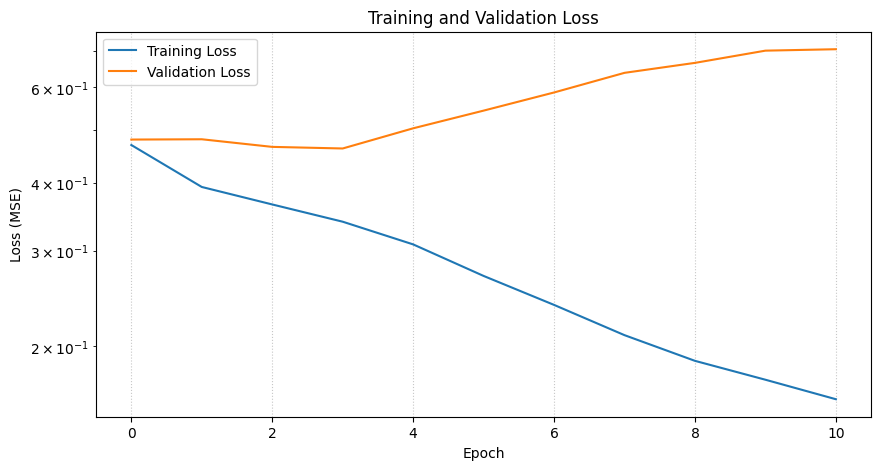


Osa 6: Koulutuksen suoritus - VALMIS (tai ohitettu/epäonnistunut)


In [7]:
# @title 6. Mallin Koulutus (Suoritus)

# --- Koulutetaan malli (jos data ja asetukset ok) ---
# Lisätty debug-tuloste ennen ehtoa
print(f"\nTarkistetaan ennen koulutusta: train_loader is {'olemassa' if train_loader is not None else 'None'}, INPUT_SIZE = {INPUT_SIZE}")

# Alustetaan model Noneksi siltä varalta että koulutus ei käynnisty tai epäonnistuu
model = None
train_losses = None
valid_losses = None

if train_loader is not None and INPUT_SIZE is not None:
    # --- Mallin, häviöfunktion ja optimoijan alustus ---
    # Varmistetaan, että INPUT_SIZE on kelvollinen
    if isinstance(INPUT_SIZE, int) and INPUT_SIZE > 0:
        try: # Try-except mallin alustuksen ympärille
            model = GRUModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_PROB).to(device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

            print("\n--- GRU-Malli ---")
            print(model)
            print(f"Ominaisuuksien määrä (Input size): {INPUT_SIZE}")
            param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Koulutettavien parametrien määrä: {param_count}")
            print("---------------------\n")

            # --- Koulutetaan malli ---
            # Try-except itse train_model kutsun ympärille
            try:
                model, train_losses, valid_losses = train_model(
                    model, train_loader, valid_loader, criterion, optimizer, EPOCHS, device, EARLY_STOPPING_PATIENCE
                )
                # Tarkistetaan paluuarvot
                if train_losses is None or valid_losses is None:
                     print("\nKoulutus keskeytyi virheeseen train_model-funktiossa.")
                     model = None # Aseta malli Noneksi, jos koulutus epäonnistui
                else:
                     print("\nKoulutus valmis.")

                     # --- Piirretään häviökäyrät (vain jos koulutus onnistui) ---
                     if train_losses and valid_losses: # Varmista että listat eivät ole tyhjiä
                        plt.figure(figsize=(10, 5))
                        plt.plot(train_losses, label='Training Loss')
                        plt.plot(valid_losses, label='Validation Loss')
                        plt.title('Training and Validation Loss')
                        plt.xlabel('Epoch')
                        plt.ylabel('Loss (MSE)')
                        # Käytä log-skaalaa vain jos minimihäviö on positiivinen ja > 0
                        min_loss = min(min(train_losses, default=1.0), min(valid_losses, default=1.0))
                        if min_loss > 1e-9 :
                           plt.yscale('log')
                           print("Käytetään logaritmista skaalaa häviökuvaajassa.")
                        else:
                           print("Käytetään lineaarista skaalaa häviökuvaajassa.")
                        plt.legend()
                        plt.grid(True, linestyle=':', alpha=0.7)
                        plt.show()
                     else:
                          print("Häviölistat ovat tyhjiä, ei voida piirtää kuvaajaa.")


            except Exception as e:
                print(f"\nVIRHE train_model-kutsun aikana: {e}")
                traceback.print_exc()
                model = None # Aseta malli Noneksi

        except Exception as e:
             print(f"\nVIRHE mallin alustuksessa: {e}")
             traceback.print_exc()
             model = None # Aseta malli Noneksi

    else:
        print(f"\nKoulutusta ei aloiteta, virheellinen INPUT_SIZE: {INPUT_SIZE}")
        model = None # Estetään jatko

else:
    print("\nKoulutusta ei voida aloittaa, koska dataa ei ole ladattu/käsitelty oikein (train_loader=None) tai INPUT_SIZE puuttuu/on virheellinen.")
    model = None # Estetään jatko

print("\nOsa 6: Koulutuksen suoritus - VALMIS (tai ohitettu/epäonnistunut)")

In [8]:
# @title 7. Mallin Arviointi ja Vertailu (Funktiot) - PARANNETTU VIRHEENKÄSITTELY

def calculate_baseline_persistence(targets_original_np, prediction_horizon):
    """Laskee naiivin persistenssi-baselinen (jakson eka arvo toistuu)."""
    print("Lasketaan Baseline-ennuste (jokainen 24h jakso = jakson eka arvo)...")
    try:
        # Oletetaan targets_original_np muoto (samples, horizon) tai (samples, horizon, 1)
        if targets_original_np.ndim == 3 and targets_original_np.shape[-1] == 1:
             # Varmistetaan että ei olla tyhjä
             if targets_original_np.shape[0] == 0: return np.zeros((0, prediction_horizon))
             first_vals_squeezed = targets_original_np[:, 0, 0] # Muoto (samples,)
             first_vals_for_repeat = first_vals_squeezed[:, np.newaxis] # Muoto (samples, 1)
        elif targets_original_np.ndim == 2:
             if targets_original_np.shape[0] == 0: return np.zeros((0, prediction_horizon))
             first_vals_for_repeat = targets_original_np[:, 0:1] # Muoto (samples, 1)
        else:
             print(f"VAROITUS: Odottamaton muoto ({targets_original_np.shape}) baseline-laskennassa!")
             return np.zeros((targets_original_np.shape[0] if targets_original_np.ndim > 0 else 0, prediction_horizon))

        if first_vals_for_repeat.size == 0:
             print("VAROITUS: Baseline sai tyhjän taulukon, palautetaan nollia.")
             return np.zeros((targets_original_np.shape[0], prediction_horizon))

        baseline_preds = np.repeat(first_vals_for_repeat, prediction_horizon, axis=1) # Muoto (samples, horizon)

        # Tarkistetaan lopullinen muoto
        expected_shape = (targets_original_np.shape[0], prediction_horizon)
        if baseline_preds.shape != expected_shape:
             print(f"VAROITUS: Baseline lopputuloksen muoto ({baseline_preds.shape}) ei ole odotettu ({expected_shape}). Yritetään korjata.")
             try:
                  baseline_preds = baseline_preds.reshape(expected_shape)
             except:
                  print("VIRHE: Baseline-muodon korjaus epäonnistui.")
                  return np.zeros(expected_shape)

        return baseline_preds
    except Exception as e:
        print(f"VIRHE baseline-laskennassa: {e}")
        traceback.print_exc()
        try: # Yritetään palauttaa oikean muotoisia nollia
             return np.zeros((targets_original_np.shape[0], prediction_horizon))
        except: return None


def evaluate_model_performance(model, test_loader, device, o3_scaler, o3_threshold_8h, prediction_horizon):
    """Arvioi mallia testidatalla, laskee metriikat ja vertaa baselineen (PARANNETTU VIRHEIDENKÄSITTELY)."""
    print("\n--- evaluate_model_performance -funktion suoritus alkaa ---")

    # Alkutarkistukset
    if model is None: print("evaluate_model_performance: Malli puuttuu."); return None, None
    if test_loader is None: print("evaluate_model_performance: Testilataaja puuttuu."); return None, None
    if o3_scaler is None: print("evaluate_model_performance: O3-skaalain puuttuu."); return None, None

    preds_original_scale = None
    targets_original_squeezed = None # Alustetaan Noneksi

    try: # Kääritään koko toiminnallisuus try-exceptiin
        model.eval() # Arviointitila
        all_preds_scaled_list = []
        all_targets_original_list = []

        print("Aloitetaan ennusteiden tekeminen testidatalla...")
        if len(test_loader.dataset) == 0:
             print("Testidata on tyhjä, ei voida tehdä ennusteita.")
             return None, None

        with torch.no_grad():
            # Huom: test_loader tuottaa nyt (inputs, targets_original_batch)
            for inputs, targets_original_batch in tqdm(test_loader, desc="Testaus (evaluate)"):
                inputs = inputs.to(device)
                outputs_scaled = model(inputs)
                all_preds_scaled_list.append(outputs_scaled.cpu().numpy())
                # targets_original_batch muoto: (batch, horizon, 1)
                all_targets_original_list.append(targets_original_batch.cpu().numpy())
        print("Ennusteiden tekeminen valmis.")

        # Varmista, ettei listat ole tyhjiä ennen concatenatea
        if not all_preds_scaled_list or not all_targets_original_list:
            print("VIRHE: Ennusteiden tai kohteiden keräys epäonnistui (listat tyhjiä).")
            return None, None

        all_preds_scaled = np.concatenate(all_preds_scaled_list, axis=0)
        all_targets_original = np.concatenate(all_targets_original_list, axis=0) # Muoto (samples, horizon, 1)

        print("Aloitetaan ennusteiden skaalauksen kääntö...")
        n_samples = all_preds_scaled.shape[0]
        n_features_out = all_preds_scaled.shape[1]
        preds_reshaped = all_preds_scaled.reshape(-1, 1)
        preds_original_scale = o3_scaler.inverse_transform(preds_reshaped).reshape(n_samples, n_features_out) # Muoto (samples, horizon)
        print("GRU-mallin ennusteet käännetty alkuperäiseen skaalaan.")

        print("Aloitetaan kohdearvojen muodon tarkistus/muokkaus...")
        if all_targets_original.ndim == 3 and all_targets_original.shape[-1] == 1:
            print(f"Muutetaan kohdemuoto {all_targets_original.shape} -> 2D käyttämällä squeeze(-1)...")
            targets_original_squeezed = all_targets_original.squeeze(-1) # Muoto (samples, horizon)
        elif all_targets_original.ndim == 2:
             targets_original_squeezed = all_targets_original # Muoto on jo oikea
             print(f"Kohdemuoto on jo 2D: {targets_original_squeezed.shape}")
        else:
            print(f"VIRHE: Odottamaton kohdemuoto ({all_targets_original.shape}) metriikoiden laskentaa varten!")
            raise ValueError("Virheellinen kohdemuoto metriikoiden laskentaan.")

        print("Kohdemuoto tarkistettu/muokattu.")
        if targets_original_squeezed is None: raise ValueError("targets_original_squeezed on None muokkauksen jälkeen!")
        if targets_original_squeezed.shape != preds_original_scale.shape:
             raise ValueError(f"Muodot eivät täsmää ennen metriikoiden laskentaa: Pred={preds_original_scale.shape}, Target={targets_original_squeezed.shape}")


        # --- Laske regressiometriikat (GRU) ---
        print("Lasketaan GRU-mallin regressiometriikat...")
        rmse_gru = np.sqrt(mean_squared_error(targets_original_squeezed, preds_original_scale))
        mae_gru = mean_absolute_error(targets_original_squeezed, preds_original_scale)
        print(f"\n--- GRU-Mallin Arviointi (kaikki {prediction_horizon} tuntia) ---")
        print(f"RMSE: {rmse_gru:.4f} µg/m³")
        print(f"MAE:  {mae_gru:.4f} µg/m³")

        # --- Laske Baseline ---
        baseline_preds_original = calculate_baseline_persistence(all_targets_original, prediction_horizon) # Käyttää 3D-muotoa sisäisesti
        if baseline_preds_original is None: raise ValueError("Baseline-laskenta palautti None.")

        # --- Laske regressiometriikat (Baseline) ---
        print("Lasketaan Baseline-mallin regressiometriikat...")
        if baseline_preds_original.shape != targets_original_squeezed.shape:
             print(f"VAROITUS: Baseline-ennusteen muoto ({baseline_preds_original.shape}) ei täsmää kohteen muotoon ({targets_original_squeezed.shape})")
             rmse_baseline, mae_baseline = None, None
        else:
            rmse_baseline = np.sqrt(mean_squared_error(targets_original_squeezed, baseline_preds_original))
            mae_baseline = mean_absolute_error(targets_original_squeezed, baseline_preds_original)
            print(f"\n--- Baseline-Mallin Arviointi (Naiivi Persistenssi) ---")
            print(f"RMSE: {rmse_baseline:.4f} µg/m³")
            print(f"MAE:  {mae_baseline:.4f} µg/m³")

        # --- Vertailu ---
        print("\n--- Vertailu Baselineen ---")
        # ... (vertailutulostukset kuten ennen) ...
        if rmse_gru is not None and rmse_baseline is not None:
            improvement_rmse = rmse_baseline - rmse_gru
            print(f"GRU vs Baseline RMSE: {improvement_rmse:+.4f} µg/m³ ({'GRU parempi' if improvement_rmse > 0 else 'Baseline parempi tai sama'})")
        else: print("RMSE-vertailua ei voida tehdä.")
        if mae_gru is not None and mae_baseline is not None:
            improvement_mae = mae_baseline - mae_gru
            print(f"GRU vs Baseline MAE:  {improvement_mae:+.4f} µg/m³ ({'GRU parempi' if improvement_mae > 0 else 'Baseline parempi tai sama'})")
        else: print("MAE-vertailua ei voida tehdä.")

        # --- 8h Liukuvan keskiarvon laskenta ---
        targets_for_rolling = targets_original_squeezed # Käytetään jo tarkistettua 2D-muotoa
        warnings_actual = []
        warnings_pred = []
        print(f"\nLasketaan 8h liukuvia keskiarvoja ja verrataan kynnysarvoon ({o3_threshold_8h} µg/m³)...")

        # Varmistetaan vielä muodot ennen looppia
        if preds_original_scale.shape != targets_for_rolling.shape:
             raise ValueError(f"Muodot eivät vieläkään täsmää ennen liukuvien keskiarvojen laskentaa: Pred={preds_original_scale.shape}, Target={targets_for_rolling.shape}")

        for i in range(n_samples):
            actual_24h = targets_for_rolling[i, :]
            pred_24h = preds_original_scale[i, :]
            actual_series = pd.Series(actual_24h)
            pred_series = pd.Series(pred_24h)
            actual_8h_avg = actual_series.rolling(window=8, min_periods=1).mean()
            pred_8h_avg = pred_series.rolling(window=8, min_periods=1).mean()
            actual_warning_triggered = actual_8h_avg.max() > o3_threshold_8h
            pred_warning_triggered = pred_8h_avg.max() > o3_threshold_8h
            warnings_actual.append(actual_warning_triggered)
            warnings_pred.append(pred_warning_triggered)

        warnings_actual = np.array(warnings_actual)
        warnings_pred = np.array(warnings_pred)
        print("Liukuvien keskiarvojen laskenta valmis.")

        # --- Tulosta 8h varoitusmetriikat ---
        print("\n--- 8h Liukuvan Keskiarvon Varoitustason Ylityksen Arviointi (GRU-malli) ---")
        # ... (tulostukset kuten ennen) ...
        print(f"Todellisia varoitusjaksoja testidatassa (> {o3_threshold_8h} µg/m³): {warnings_actual.sum()} / {n_samples}")
        print(f"Ennustettuja varoitusjaksoja (GRU):                      {warnings_pred.sum()} / {n_samples}")

        if warnings_actual.sum() > 0 or warnings_pred.sum() > 0:
            print("\nSekaannusmatriisi (Confusion Matrix) varoituksille (GRU):")
            cm = confusion_matrix(warnings_actual, warnings_pred, labels=[False, True])
            cm_df = pd.DataFrame(cm, index=['Todellinen EI Varoitusta', 'Todellinen KYLLÄ Varoitus'],
                               columns=['Ennuste EI', 'Ennuste KYLLÄ'])
            print(cm_df)
            print("\nLuokitteluraportti varoituksille (GRU):")
            report = classification_report(warnings_actual, warnings_pred, target_names=['Ei Varoitusta', 'Varoitus'], labels=[False, True], zero_division=0)
            print(report)
            recall_warning = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
            precision_warning = cm[1, 1] / (cm[0, 1] + cm[1, 1]) if (cm[0, 1] + cm[1, 1]) > 0 else 0
            print(f"\n---> TÄRKEIMMÄT VAROITUSMETRIIKAT:")
            print(f"  Recall (Herkkyys) 'Varoitus'-luokalle: {recall_warning:.4f}")
            print(f"    (Kuinka monta % todellisista varoitusjaksoista tunnistettiin?)\n")
            print(f"  Precision (Tarkkuus) 'Varoitus'-luokalle: {precision_warning:.4f}")
            print(f"    (Kuinka monta % mallin antamista varoituksista oli oikeita?)\n")
        else:
            print("\nEi todellisia eikä ennustettuja varoitusjaksoja testidatassa kynnysarvolla.")
            print("   -> Luokittelumetriikoita ei voida laskea.")


        print("\n--- evaluate_model_performance -funktion suoritus päättyi onnistuneesti ---")
        # Palauta alkuperäiset ennusteet ja kohteet (squeezeituna)
        return preds_original_scale, targets_original_squeezed # Palautetaan puristettu kohde

    except Exception as e:
        print(f"\n-----> VIRHE evaluate_model_performance -FUNKTIOSSA <-----")
        print(f"Virhetyyppi: {type(e).__name__}")
        print(f"Virheilmoitus: {e}")
        print("Traceback:")
        traceback.print_exc() # Tulosta koko traceback
        print("---------------------------------------------------------")
        print("Palautetaan None, None, koska arviointi epäonnistui.")
        return None, None # Palauta None virhetilanteessa

print("Osa 7: Arviointifunktioiden määrittely - OK")

Osa 7: Arviointifunktioiden määrittely - OK


In [11]:
# @title 8. Mallin Arviointi (Suoritus) (Oikea Sijainti)

# --- Alustetaan tulosmuuttujat ---
if 'test_preds_orig' not in locals(): test_preds_orig = None
if 'test_targets_orig' not in locals(): test_targets_orig = None
evaluation_successful = False # Lipuke onnistumiselle

# --- Suoritetaan arviointi (jos malli koulutettu ja funktio määritelty) ---
# Tarkistetaan, onko model olemassa ja koulutettu (ei None)
if 'model' in locals() and model is not None:
    # Tarkistetaan, onko arviointifunktio määritelty
    if 'evaluate_model_performance' in locals():
        # Varmista myös muiden tarvittavien muuttujien olemassaolo
        if 'test_loader' in locals() and test_loader is not None and \
           'o3_scaler' in locals() and o3_scaler is not None and \
           'device' in locals() and \
           'O3_THRESHOLD_8H_AVG' in locals() and \
           'PREDICTION_HORIZON' in locals():

            print("\n--- Mallin Arviointi (Suoritus) ---")
            # Kutsutaan paranneltua arviointifunktiota
            temp_preds, temp_targets = evaluate_model_performance(
                model, test_loader, device, o3_scaler, O3_THRESHOLD_8H_AVG, PREDICTION_HORIZON
            )
            # Päivitä globaalit muuttujat vain jos palautus ei ollut None
            if temp_preds is not None and temp_targets is not None:
                 test_preds_orig = temp_preds
                 test_targets_orig = temp_targets
                 evaluation_successful = True
                 print("Arviointi suoritettu onnistuneesti.")
            else:
                 print("Arviointi epäonnistui (evaluate_model_performance palautti None).")
                 test_preds_orig, test_targets_orig = None, None # Varmista Noneksi

        else:
            print("\nArviointia ei voida suorittaa puuttuvien muuttujien vuoksi (test_loader, o3_scaler, tms.).")
    else:
        print("\nArviointia ei voida suorittaa, koska `evaluate_model_performance`-funktiota ei ole määritelty (aja Osa 7).")
else:
     print("\nArviointia ei voida suorittaa, koska mallia (`model`) ei ole koulutettu onnistuneesti (aja Osa 6).")

if evaluation_successful:
     print("\nOsa 8: Arvioinnin suoritus - VALMIS")
else:
     print("\nOsa 8: Arvioinnin suoritus - EPÄONNISTUI / OHITETTIIN")


--- Mallin Arviointi (Suoritus) ---

--- evaluate_model_performance -funktion suoritus alkaa ---
Aloitetaan ennusteiden tekeminen testidatalla...


Testaus (evaluate):   0%|          | 0/102 [00:00<?, ?it/s]

Ennusteiden tekeminen valmis.
Aloitetaan ennusteiden skaalauksen kääntö...
GRU-mallin ennusteet käännetty alkuperäiseen skaalaan.
Aloitetaan kohdearvojen muodon tarkistus/muokkaus...
Muutetaan kohdemuoto (6483, 24, 1) -> 2D käyttämällä squeeze(-1)...
Kohdemuoto tarkistettu/muokattu.
Lasketaan GRU-mallin regressiometriikat...

--- GRU-Mallin Arviointi (kaikki 24 tuntia) ---
RMSE: 13.7105 µg/m³
MAE:  10.3365 µg/m³
Lasketaan Baseline-ennuste (jokainen 24h jakso = jakson eka arvo)...
Lasketaan Baseline-mallin regressiometriikat...

--- Baseline-Mallin Arviointi (Naiivi Persistenssi) ---
RMSE: 17.2667 µg/m³
MAE:  12.3915 µg/m³

--- Vertailu Baselineen ---
GRU vs Baseline RMSE: +3.5561 µg/m³ (GRU parempi)
GRU vs Baseline MAE:  +2.0550 µg/m³ (GRU parempi)

Lasketaan 8h liukuvia keskiarvoja ja verrataan kynnysarvoon (120 µg/m³)...
Liukuvien keskiarvojen laskenta valmis.

--- 8h Liukuvan Keskiarvon Varoitustason Ylityksen Arviointi (GRU-malli) ---
Todellisia varoitusjaksoja testidatassa (> 120 

In [12]:
# @title 9. Viimeisimmän Ennustejakson Huippuarvo (Oikea Sijainti)

print("\n--- Analysoidaan viimeisintä ennustejaksoa ---")

# Varmistetaan, että arvioinnin tulokset ovat olemassa ja oikean tyyppisiä
# (Oletetaan, että Osa 8, joka kutsuu evaluate_model_performance, on ajettu)
latest_analysis_possible = False
if 'test_preds_orig' in locals() and isinstance(test_preds_orig, np.ndarray) and \
   'test_timestamps' in locals() and test_timestamps is not None:

    if len(test_preds_orig) > 0 and len(test_timestamps) == len(test_preds_orig):
        latest_analysis_possible = True
        try:
            # Otetaan viimeisin ennustettu 24h jakso
            latest_prediction_sequence = test_preds_orig[-1] # Muoto (24,)

            # Otetaan viimeisen ennustejakson alkuaika
            prediction_start_time = test_timestamps[-1]

            # Etsitään korkein arvo ja sen indeksi (0-23) jaksolta
            max_index = np.argmax(latest_prediction_sequence)
            max_value = latest_prediction_sequence[max_index]

            # Lasketaan korkeimman arvon tarkka aika
            time_of_max = prediction_start_time + pd.Timedelta(hours=int(max_index))

            print(f"\nViimeisin ennustettu 24h jakso alkaa: {prediction_start_time.strftime('%Y-%m-%d %H:%M')}")
            print("-" * 40)
            print(f"Korkein ennustettu O3-arvo: {max_value:.2f} µg/m³")
            print(f"Ajankohta: {time_of_max.strftime('%A, %d.%m.%Y klo %H:%M')}")
            print("-" * 40)

        except IndexError:
             print("\nVirhe viimeisimmän jakson indeksissä (todennäköisesti tyhjä data).")
             latest_analysis_possible = False # Merkitään epäonnistuneeksi
        except Exception as e:
            print(f"\nVirhe viimeisimmän ennustejakson analysoinnissa: {e}")
            traceback.print_exc()
            latest_analysis_possible = False # Merkitään epäonnistuneeksi

    else:
        print("\nEi voitu analysoida viimeisintä jaksoa: Ennusteita tai aikaleimoja ei löytynyt tai niiden pituudet eivät täsmää.")
else:
    print("\nEi voitu analysoida viimeisintä jaksoa, koska arvioinnin tuloksia ('test_preds_orig', 'test_timestamps') ei ole saatavilla (Aja ensin Osa 8).")

if latest_analysis_possible:
     print("\nOsa 9: Huippuarvon analyysi - VALMIS")
else:
     print("\nOsa 9: Huippuarvon analyysi - EPÄONNISTUI / OHITETTIIN")


--- Analysoidaan viimeisintä ennustejaksoa ---

Viimeisin ennustettu 24h jakso alkaa: 2025-04-01 00:00
----------------------------------------
Korkein ennustettu O3-arvo: 71.46 µg/m³
Ajankohta: Tuesday, 01.04.2025 klo 17:00
----------------------------------------

Osa 9: Huippuarvon analyysi - VALMIS



--- Visualisointi (Suoritus) ---

Piirretään visualisoinnit testijaksolle #5390 (indeksi)...


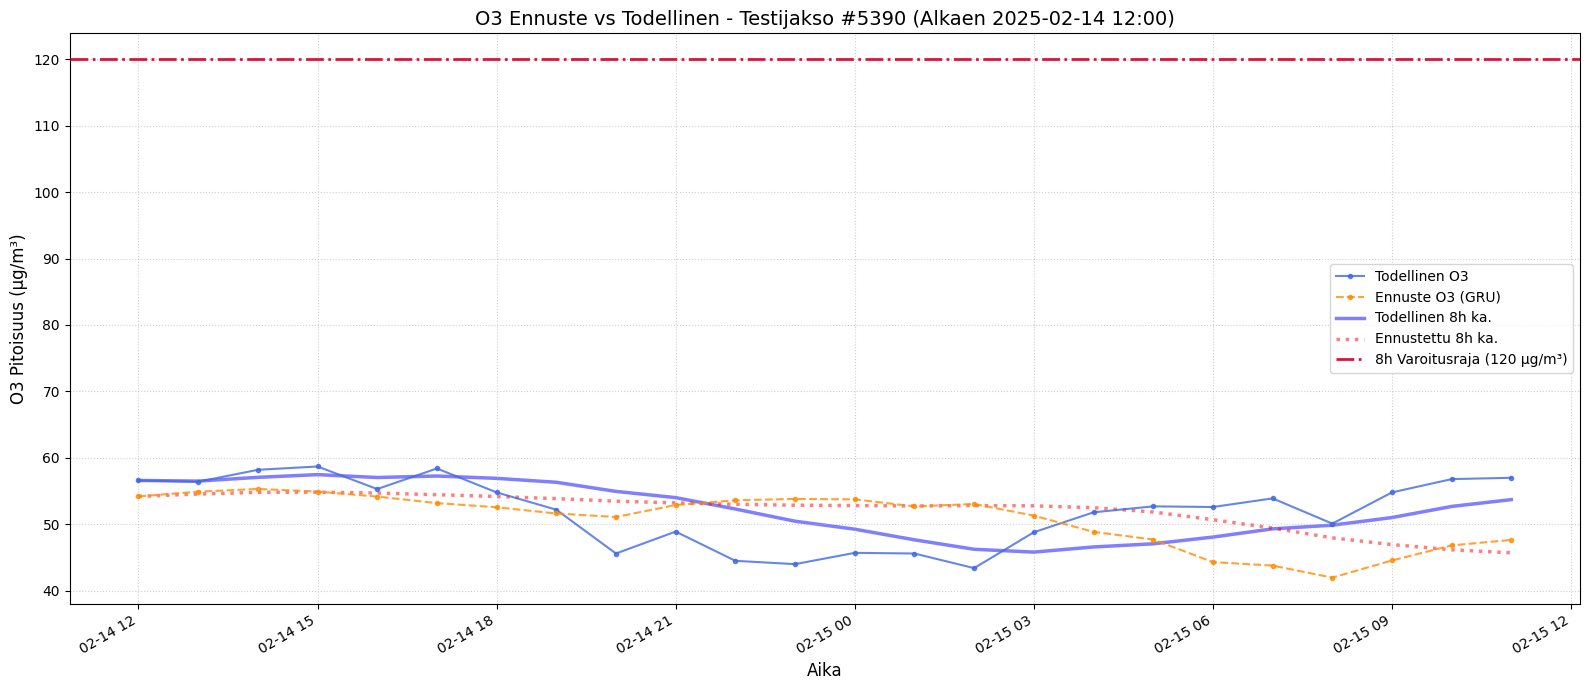

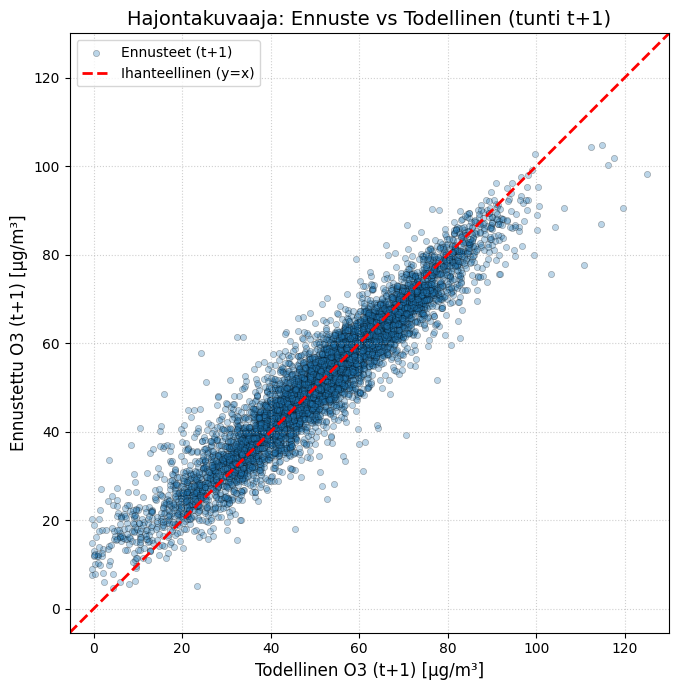

In [13]:
# @title 10. Visualisointi (Suoritus) (Oikea Sijainti)

print("\n--- Visualisointi (Suoritus) ---")
# --- Suoritetaan visualisointi (jos arviointi onnistui ja palautti tulokset) ---
# Varmistetaan myös test_timestamps muuttujan olemassaolo
if 'test_timestamps' not in locals(): test_timestamps = None

# Tarkistetaan, että molemmat (ennusteet JA kohteet) ovat olemassa ja validit
if 'test_preds_orig' in locals() and isinstance(test_preds_orig, np.ndarray) and \
   'test_targets_orig' in locals() and isinstance(test_targets_orig, np.ndarray):

    if test_timestamps is not None:
        num_test_samples = len(test_preds_orig)

        # Tarkistetaan pituudet ennen jatkamista
        lengths_ok = (num_test_samples > 0 and
                      test_targets_orig.shape[0] == num_test_samples and
                      len(test_timestamps) == num_test_samples)

        if lengths_ok:
            # --- Kuvaaja 1: Esimerkkijakson ennuste vs. Todellinen ---
            sample_idx = np.random.randint(0, num_test_samples)
            print(f"\nPiirretään visualisoinnit testijaksolle #{sample_idx} (indeksi)...")

            try: # Try-except kuvaajan piirron ympärille
                plt.figure(figsize=(16, 7))
                start_time = test_timestamps[sample_idx]
                time_axis = pd.date_range(start=start_time, periods=PREDICTION_HORIZON, freq='h')

                targets_plot = test_targets_orig[sample_idx, :] # Pitäisi olla 1D (horizon,)
                if targets_plot.ndim != 1: raise ValueError(f"targets_plot muoto {targets_plot.shape}, odotettiin 1D")

                plt.plot(time_axis, targets_plot, label='Todellinen O3', marker='.', linewidth=1.5, alpha=0.8, color='royalblue', zorder=3)
                plt.plot(time_axis, test_preds_orig[sample_idx, :], label='Ennuste O3 (GRU)', marker='.', linestyle='--', linewidth=1.5, alpha=0.8, color='darkorange', zorder=4)

                try: # Try-except liukuville keskiarvoille
                    actual_series_sample = pd.Series(targets_plot, index=time_axis)
                    pred_series_sample = pd.Series(test_preds_orig[sample_idx, :], index=time_axis)
                    actual_8h_avg_sample = actual_series_sample.rolling(window=8, min_periods=1).mean()
                    pred_8h_avg_sample = pred_series_sample.rolling(window=8, min_periods=1).mean()

                    plt.plot(time_axis, actual_8h_avg_sample, label='Todellinen 8h ka.', color='blue', linestyle='-', linewidth=2.5, alpha=0.5, zorder=1)
                    plt.plot(time_axis, pred_8h_avg_sample, label='Ennustettu 8h ka.', color='red', linestyle=':', linewidth=2.5, alpha=0.5, zorder=2)
                except Exception as e_roll:
                     print(f"VAROITUS: Virhe liukuvien keskiarvojen laskennassa tai piirrossa: {e_roll}")

                plt.axhline(O3_THRESHOLD_8H_AVG, color='crimson', linestyle='-.', linewidth=2, label=f'8h Varoitusraja ({O3_THRESHOLD_8H_AVG} µg/m³)', zorder=5)
                plt.title(f'O3 Ennuste vs Todellinen - Testijakso #{sample_idx} (Alkaen {start_time.strftime("%Y-%m-%d %H:%M")})', fontsize=14)
                plt.xlabel('Aika', fontsize=12); plt.ylabel('O3 Pitoisuus (µg/m³)', fontsize=12)
                plt.legend(loc='best', fontsize=10); plt.grid(True, linestyle=':', alpha=0.6)
                plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()

            except Exception as e_fig1:
                 print(f"VIRHE Kuvaaja 1 piirrossa: {e_fig1}")
                 traceback.print_exc()


            # --- Kuvaaja 2: Hajontakuvaaja (Ennuste t+1 vs Todellinen t+1) ---
            try: # Try-except kuvaajan piirron ympärille
                plt.figure(figsize=(7, 7))
                preds_t_plus_1 = test_preds_orig[:, 0]
                targets_t_plus_1 = test_targets_orig[:, 0] # Pitäisi olla 1D (samples,)

                if targets_t_plus_1.ndim != 1 or preds_t_plus_1.ndim != 1:
                     raise ValueError(f"Hajontakuvaajan datamuodot väärin: Target={targets_t_plus_1.shape}, Pred={preds_t_plus_1.shape}")

                plt.scatter(targets_t_plus_1, preds_t_plus_1, alpha=0.3, label='Ennusteet (t+1)', s=20, edgecolors='k', linewidth=0.5)
                valid_targets = targets_t_plus_1[~np.isnan(targets_t_plus_1) & ~np.isinf(targets_t_plus_1)]
                valid_preds = preds_t_plus_1[~np.isnan(preds_t_plus_1) & ~np.isinf(preds_t_plus_1)]

                if len(valid_targets) > 0 and len(valid_preds) > 0:
                     min_val = min(valid_targets.min(), valid_preds.min()) - 5
                     max_val = max(valid_targets.max(), valid_preds.max()) + 5
                     if np.isfinite(min_val) and np.isfinite(max_val) and max_val > min_val:
                         plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Ihanteellinen (y=x)')
                         plt.xlim(min_val, max_val); plt.ylim(min_val, max_val)
                     else: print("VAROITUS: Ei voitu asettaa järkeviä akseleiden rajoja hajontakuvaajalle.")
                else: print("VAROITUS: Ei voitu määrittää akseleiden rajoja hajontakuvaajalle (ei validia dataa).")

                plt.title('Hajontakuvaaja: Ennuste vs Todellinen (tunti t+1)', fontsize=14)
                plt.xlabel('Todellinen O3 (t+1) [µg/m³]', fontsize=12); plt.ylabel('Ennustettu O3 (t+1) [µg/m³]', fontsize=12)
                plt.grid(True, linestyle=':', alpha=0.6); plt.legend(fontsize=10)
                plt.gca().set_aspect('equal', adjustable='box'); plt.tight_layout(); plt.show()

            except Exception as e_fig2:
                 print(f"VIRHE Kuvaaja 2 piirrossa: {e_fig2}")
                 traceback.print_exc()

        else:
            print("Testidataa ei löytynyt visualisointia varten tai pituudet eivät täsmää.")
            # Tulostetaan pituudet debuggausta varten
            print(f"Num test samples (preds): {num_test_samples if test_preds_orig is not None else 'N/A'}")
            if test_targets_orig is not None: print(f"Targets shape: {test_targets_orig.shape}")
            if test_timestamps is not None: print(f"Timestamps len: {len(test_timestamps)}")

    else:
        missing_vars_msg = []
        if test_preds_orig is None: missing_vars_msg.append('test_preds_orig')
        if test_targets_orig is None: missing_vars_msg.append('test_targets_orig')
        if test_timestamps is None: missing_vars_msg.append('test_timestamps')
        print(f"\nVisualisointia ei voida suorittaa puuttuvien/virheellisten tulosten vuoksi: {missing_vars_msg}")
else:
     # Jos päädyttiin tänne, joko malli puuttui tai arviointi epäonnistui aiemmin
     print("\nVisualisointia ei suoriteta, koska mallia ei ole koulutettu tai arviointi epäonnistui/ohitettiin.")


# Varmistetaan, että skriptin lopputuloste tulee aina
if 'print' in locals():
     print("\n--- Skriptilohkon (Osa 10) suoritus päättyi ---")